In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

import json
from sagemaker.predictor import json_deserializer

<h1>FM Cloud Prediction Invocation Template</h1>
<h4>Invoke SageMaker Prediction Service</h4>

In [2]:
import boto3
import re
from sagemaker import get_execution_role
import sagemaker

In [3]:
# Acquire a realtime endpoint
endpoint_name = 'fm-movie-v4'
predictor_sparse = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

In [4]:
# Read Dimension: Number of unique users + Number of unique movies in our dataset
dim_movie = 0

# Update movie dimension - from file used for training 
with open(r'ml-latest-small/movie_dimension.txt','r') as f:
    dim_movie = int(f.read())

In [5]:
print(dim_movie)

10334


In [6]:
def fm_sparse_serializer(data):
    js = {'instances': []}
    for row in data:
        
        column_list = row.tolist()
        value_list = np.ones(len(column_list),dtype=int).tolist()
       
        js['instances'].append({'data':{'features': { 'keys': column_list, 'shape':[dim_movie], 'values': value_list}}})
    return json.dumps(js)

In [7]:
# Testing
print(fm_sparse_serializer([np.array([341,1416]),np.array([209,2640]),np.array([164,1346])]))

{"instances": [{"data": {"features": {"keys": [341, 1416], "shape": [10334], "values": [1, 1]}}}, {"data": {"features": {"keys": [209, 2640], "shape": [10334], "values": [1, 1]}}}, {"data": {"features": {"keys": [164, 1346], "shape": [10334], "values": [1, 1]}}}]}


In [ ]:
# Initialize Predictor with correct configuration

In [8]:
predictor_sparse.content_type = 'application/json'
predictor_sparse.serializer =  fm_sparse_serializer
predictor_sparse.deserializer = json_deserializer

In [ ]:
# Test libSVM

In [9]:
# Load the test file in svm format. '5 341:1 1416:1'
test_file = r'ml-latest-small/user_movie_test.svm'

In [10]:
df_test = pd.read_csv(test_file, sep=' ', names=['rating','user_index','movie_index'])

In [11]:
df_test.head()

,rating,user_index,movie_index
0,4.0,561:1,2822:1
1,3.5,473:1,2600:1
2,4.5,361:1,2548:1
3,1.0,20:1,3582:1
4,5.0,468:1,2867:1


In [12]:
# update column to contain only the one hot encoded index
df_test.user_index = df_test.user_index.map(lambda value: int(value.split(':')[0]))
df_test.movie_index = df_test.movie_index.map(lambda value: int(value.split(':')[0]))

In [13]:
df_test.head()

,rating,user_index,movie_index
0,4.0,561,2822
1,3.5,473,2600
2,4.5,361,2548
3,1.0,20,3582
4,5.0,468,2867


In [14]:
df_test.shape

(30251, 3)

In [15]:
# For large number of predictions, we can split the input data and
# Query the prediction service.
# array_split is convenient to specify how many splits are needed
def get_predictions(predictor, arr_features):
    predictions = []
    for arr in np.array_split(arr_features,100):        
        if arr.shape[0] > 0:
            print (arr.shape, end=' ')
            result = predictor.predict(arr)
            predictions += [values['score'] for values in result['predictions']]
    return predictions

In [16]:
%time predictions = get_predictions(predictor_sparse, df_test[['user_index','movie_index']].as_matrix())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


(303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) CPU times: user 729 ms, sys: 21.3 ms, total: 751 ms
Wall time: 23.8 s


In [17]:
df_test['predictions'] = predictions

In [18]:
df_test.head()

,rating,user_index,movie_index,predictions
0,4.0,561,2822,3.306559
1,3.5,473,2600,3.339083
2,4.5,361,2548,4.247659
3,1.0,20,3582,3.047000
4,5.0,468,2867,3.828322


In [19]:
import sklearn.metrics as metrics

In [20]:
print('RMSE: ', metrics.mean_squared_error(df_test.rating, df_test.predictions)**.5)

RMSE:  0.9026666796324652


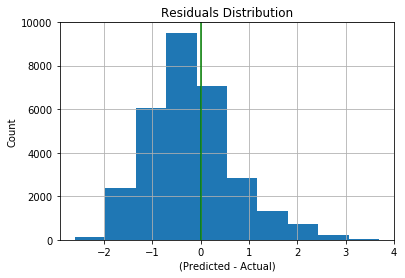

In [21]:
# Training Data Residuals
residuals = (df_test.predictions - df_test.rating)

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')

## Get Prediction for a single user and all movies

In [22]:
# Load the one hot coded index values in svm format
test_file = r'ml-latest-small/one_hot_enc_movies.svm'

In [23]:
df_one_user_test = pd.read_csv(test_file,sep=' ',names=['movieId','user_index','movie_index'])
df_one_user_test.user_index = df_one_user_test.user_index.map(lambda value: int(value.split(':')[0]))
df_one_user_test.movie_index = df_one_user_test.movie_index.map(lambda value: int(value.split(':')[0]))

In [24]:
df_one_user_test.head()

,movieId,user_index,movie_index
0,108932,0,8949
1,3671,0,3339
2,179819,0,10237
3,2506,0,2496
4,3147,0,2980


In [25]:
df_one_user_test.shape[0]

9724

In [26]:
%time predictions = get_predictions(predictor_sparse, df_one_user_test[['user_index','movie_index']].as_matrix())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


(98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) CPU times: user 450 ms, sys: 19.5 ms, total: 469 ms
Wall time: 7.66 s


In [27]:
df_one_user_test['rating_predicted'] = predictions

In [28]:
df_one_user_test.head()

,movieId,user_index,movie_index,rating_predicted
0,108932,0,8949,3.931738
1,3671,0,3339,3.958902
2,179819,0,10237,3.501196
3,2506,0,2496,3.723770
4,3147,0,2980,4.280543


In [29]:
df_movies = pd.read_csv(r'ml-latest-small/movies_genre.csv')

In [30]:
df_movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_one_user_test = df_one_user_test.merge(df_movies, on='movieId')

In [32]:
df_one_user_test.head()

,movieId,user_index,movie_index,rating_predicted,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,108932,0,8949,3.931738,The Lego Movie (2014),Action|Adventure|Animation|Children|Comedy|Fan...,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,3671,0,3339,3.958902,Blazing Saddles (1974),Comedy|Western,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,179819,0,10237,3.501196,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3,2506,0,2496,3.723770,"Other Sister, The (1999)",Comedy|Drama|Romance,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3147,0,2980,4.280543,"Green Mile, The (1999)",Crime|Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_one_user_test.sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

,title,rating_predicted,genres
82,"Shawshank Redemption, The (1994)",4.761199,Crime|Drama
291,Forrest Gump (1994),4.569768,Comedy|Drama|Romance|War
378,Star Wars: Episode IV - A New Hope (1977),4.567432,Action|Adventure|Sci-Fi
205,"Matrix, The (1999)",4.550276,Action|Sci-Fi|Thriller
671,Pulp Fiction (1994),4.549993,Comedy|Crime|Drama|Thriller
196,"Godfather, The (1972)",4.545909,Crime|Drama
37,"Silence of the Lambs, The (1991)",4.535047,Crime|Horror|Thriller
436,Fight Club (1999),4.533943,Action|Crime|Drama|Thriller
35,"Usual Suspects, The (1995)",4.526438,Crime|Mystery|Thriller
440,Schindler's List (1993),4.511497,Drama|War


In [34]:
# Any Action Movies?
df_one_user_test[df_one_user_test.Action == 1].sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

,title,rating_predicted,genres
378,Star Wars: Episode IV - A New Hope (1977),4.567432,Action|Adventure|Sci-Fi
205,"Matrix, The (1999)",4.550276,Action|Sci-Fi|Thriller
436,Fight Club (1999),4.533943,Action|Crime|Drama|Thriller
758,Raiders of the Lost Ark (Indiana Jones and the...,4.490098,Action|Adventure
170,Star Wars: Episode V - The Empire Strikes Back...,4.487238,Action|Adventure|Sci-Fi
346,"Princess Bride, The (1987)",4.411876,Action|Adventure|Comedy|Fantasy|Romance
102,"Dark Knight, The (2008)",4.411333,Action|Crime|Drama|IMAX
105,Braveheart (1995),4.402278,Action|Drama|War
99,"Lord of the Rings: The Return of the King, The...",4.400729,Action|Adventure|Drama|Fantasy
293,Inception (2010),4.390327,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX


In [35]:
# What about comedy?
df_one_user_test[df_one_user_test.Comedy == 1].sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

,title,rating_predicted,genres
291,Forrest Gump (1994),4.569768,Comedy|Drama|Romance|War
671,Pulp Fiction (1994),4.549993,Comedy|Crime|Drama|Thriller
346,"Princess Bride, The (1987)",4.411876,Action|Adventure|Comedy|Fantasy|Romance
219,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.407191,Comedy|Romance
554,Snatch (2000),4.358086,Comedy|Crime|Thriller
89,Monty Python and the Holy Grail (1975),4.351487,Adventure|Comedy|Fantasy
969,Fargo (1996),4.321835,Comedy|Crime|Drama|Thriller
315,Finding Nemo (2003),4.305321,Adventure|Animation|Children|Comedy
369,Dr. Strangelove or: How I Learned to Stop Worr...,4.295539,Comedy|War
1258,Trainspotting (1996),4.294485,Comedy|Crime|Drama


In [36]:
# And Drama
df_one_user_test[df_one_user_test.Drama == 1].sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

,title,rating_predicted,genres
82,"Shawshank Redemption, The (1994)",4.761199,Crime|Drama
291,Forrest Gump (1994),4.569768,Comedy|Drama|Romance|War
671,Pulp Fiction (1994),4.549993,Comedy|Crime|Drama|Thriller
196,"Godfather, The (1972)",4.545909,Crime|Drama
436,Fight Club (1999),4.533943,Action|Crime|Drama|Thriller
440,Schindler's List (1993),4.511497,Drama|War
706,"Departed, The (2006)",4.414462,Crime|Drama|Thriller
253,"Godfather: Part II, The (1974)",4.412104,Crime|Drama
102,"Dark Knight, The (2008)",4.411333,Action|Crime|Drama|IMAX
105,Braveheart (1995),4.402278,Action|Drama|War


In [38]:
df_one_user_test.user_index = 178
predictions = get_predictions(predictor_sparse, df_one_user_test[['user_index','movie_index']].as_matrix())
df_one_user_test['rating_predicted'] = predictions
df_one_user_test.sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


(98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) 

,title,rating_predicted,genres
82,"Shawshank Redemption, The (1994)",4.119818,Crime|Drama
378,Star Wars: Episode IV - A New Hope (1977),3.976380,Action|Adventure|Sci-Fi
291,Forrest Gump (1994),3.967538,Comedy|Drama|Romance|War
196,"Godfather, The (1972)",3.954304,Crime|Drama
671,Pulp Fiction (1994),3.942877,Comedy|Crime|Drama|Thriller
436,Fight Club (1999),3.940411,Action|Crime|Drama|Thriller
35,"Usual Suspects, The (1995)",3.939702,Crime|Mystery|Thriller
205,"Matrix, The (1999)",3.926472,Action|Sci-Fi|Thriller
440,Schindler's List (1993),3.923358,Drama|War
758,Raiders of the Lost Ark (Indiana Jones and the...,3.922053,Action|Adventure


In [39]:
df_one_user_test.user_index = 209
predictions = get_predictions(predictor_sparse, df_one_user_test[['user_index','movie_index']].as_matrix())
df_one_user_test['rating_predicted'] = predictions
df_one_user_test.sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


(98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) 

,title,rating_predicted,genres
82,"Shawshank Redemption, The (1994)",4.356021,Crime|Drama
378,Star Wars: Episode IV - A New Hope (1977),4.208653,Action|Adventure|Sci-Fi
291,Forrest Gump (1994),4.203150,Comedy|Drama|Romance|War
196,"Godfather, The (1972)",4.184536,Crime|Drama
35,"Usual Suspects, The (1995)",4.174284,Crime|Mystery|Thriller
436,Fight Club (1999),4.170781,Action|Crime|Drama|Thriller
671,Pulp Fiction (1994),4.165498,Comedy|Crime|Drama|Thriller
205,"Matrix, The (1999)",4.164384,Action|Sci-Fi|Thriller
37,"Silence of the Lambs, The (1991)",4.152454,Crime|Horror|Thriller
440,Schindler's List (1993),4.150835,Drama|War
